# Short video on the Izhikevich model

This video is not a complete explanation of the Izhikevich model, but only a 15s video meant as proof of feasibility for the development of a series of 20 videos.

In [1]:
#!pip install manim

## Testing we can get the right traces from the Izhikevich model implemented in our `scmc` package

In [2]:
from scmc.cmc import get_izhikevich_pop, CMC
import brian2 as br
import matplotlib.pyplot as plt
from manim import * #Axes, Scene, GREEN, BLUE, RED, UP, WHITE, UR, TAU
import numpy as np
from scipy.interpolate import interp1d

In [3]:
default_params = CMC.get_default_pop_params(nb_neurons=1, I=0)
default_params

{'a': 20. * hertz,
 'b': 200. * hertz,
 'c': -65. * mvolt,
 'd': 8. * metre ** 2 * kilogram * second ** -4 * amp ** -1,
 'I': 0,
 'nb_neurons': 1}

In [4]:
default_params = CMC.get_default_pop_params(nb_neurons=1, I=0)

neuron = get_izhikevich_pop(**default_params)
monitor = br.StateMonitor(neuron, ['v', 'I'], record=True)
network = br.Network()
network.add(neuron)
network.add(monitor)

network.run(0.5*br.second, report="text")
neuron.I = 15*br.mV/br.ms
network.run(0.5*br.second, report="text")


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
Starting simulation at t=0.5 s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s


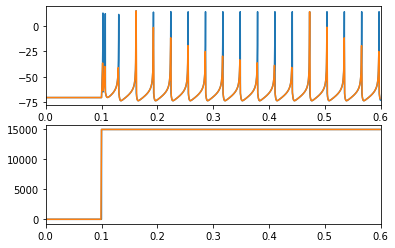

In [5]:
fig, axes = plt.subplots(2, 1)
for ax, var in zip(axes, ['v', 'I']):
    t, v = monitor.t/br.second-0.4, getattr(monitor, var)[0]/br.mV
    ax.plot(t, v)
    x = np.arange(t[0], t[-1], 0.001)
    ax.plot(x, interp1d(t, v, kind="nearest-up")(x) )
    ax.set_xlim(0, 0.6)


t, v, I = monitor.t/br.second-0.4, monitor.v[0]/br.mV, monitor.I[0]/br.mV

v = v[t>=0]
I = I[t>=0]
t = t[t>=0]


## Creating a video showing these traces as animations, along with the equations of the model

In [11]:
from manim import * #Axes, Scene, GREEN, BLUE, RED, UP, WHITE, UR, TAU
import numpy as np
from scipy.interpolate import interp1d

#config.background_color = RED
#config.frame_rate = 50
#config.frame_size = [1200,500] # [WIDTH, HEIGHT]
# config.transparent = True

# RENDER AS IMAGE: ----------------
#config.format = "png"
#config.save_last_frame = True
# config.transparent = True

# REDER AS GIF: -------------------
#config.format = "gif"


class IzhikevichFunctionPlot(Scene):

    def get_trace(self):
        """ Getting the trace of a Izhikevich neuron """
        default_params = CMC.get_default_pop_params(nb_neurons=1, I=0)

        neuron = get_izhikevich_pop(**default_params)
        monitor = br.StateMonitor(neuron, ['v', 'I'], record=True) 
        network = br.Network()
        network.add(neuron)
        network.add(monitor)

        network.run(0.5*br.second, report="text")
        neuron.I = 15*br.mV/br.ms
        network.run(0.5*br.second, report="text")

        self.t = monitor.t/br.second-0.4
        self.v = monitor.v[0]/br.mV
        self.I = monitor.I[0]/br.mV
        self.v = self.v[self.t>=0]
        self.I = self.I[self.t>=0]/1000
        self.t = self.t[self.t>=0]       

        self.func_v = interp1d(t, self.v, kind="nearest-up")
        self.func_I = interp1d(t, self.I, kind="nearest-up")


    def construct(self):
        self.get_trace()
        self.add_title()
        self.add_latex_eq()
        self.add_axes()
        self.display_animated_curves()
        self.wait()


    def add_title(self):
        text = Text("The Izhikevich\nmodel", font_size=60)
        self.add(text)
        text.shift(2.8*UP)
        text.shift(4.2*LEFT)

    def add_axes(self):

        self.axes_stim = Axes(
            x_range=[self.t[0], self.t[-1], 0.1],
            y_range=[0, 16, 15],
            x_length=10,
            y_length=0.5,
            x_axis_config={
                "numbers_to_include": np.arange(self.t.min(), self.t.max(), 0.1),
                "numbers_with_elongated_ticks": np.arange(self.t.min(), self.t.max(), 0.1),
            },
            tips=False,
        )
        self.axes_stim.add_coordinates()
        axes_stim_labels = self.axes_stim.get_axis_labels(Tex("$t$").scale(0.7), 
                                                          Tex("Stimulus (mV/ms)").scale(0.7))


        self.axes_iz = Axes(
            x_range=[self.t[0], self.t[-1], 0.1],
            y_range=[self.v.min(), self.v.max(), 20],
            x_length=10,
            y_length=2,
            #axis_config={"color": GREEN},
            x_axis_config={
                "numbers_to_include": np.arange(self.t.min(), self.t.max(), 0.1),
                "numbers_with_elongated_ticks": np.arange(self.t.min(), self.t.max(), 0.1),
            },
            tips=False,
        )
        self.axes_iz.add_coordinates()
        axes_labels = self.axes_iz.get_axis_labels(Tex("$t$").scale(0.7), 
                                                   Tex("Membrane potential (mV)").scale(0.7))
        #iz_graph = axes.plot(func, x_range=[t[0], t[-1], 0.0001], 
        #                     color=RED, use_smoothing=False)

        self.axes_stim.shift(2*DOWN)
        axes_stim_labels.shift(2*DOWN)  

        plot = VGroup(self.axes_iz)#, iz_graph)#, vert_line)
        labels = VGroup(axes_labels)#, sin_label, line_label)
        self.add(plot, labels)
        plot = VGroup(self.axes_stim)#, stim_graph,)#, vert_line)
        labels = VGroup(axes_stim_labels)#, sin_label, line_label)
        self.add(plot, labels)


    def display_animated_curves(self):
        self.t_offset = 0.0
        rate = 0.1

        def go_around_circle(mob, dt):
            self.t_offset += (dt * rate)

        ##### Izhikevich curve
        self.curve = VGroup()
        self.curve.add(Line(self.axes_iz.coords_to_point(self.t[0], self.v[0]).squeeze(),
                            self.axes_iz.coords_to_point(self.t[0], self.v[0]).squeeze()))

        self.last_t_ = float(t[0])
        def get_curve():
            last_line = self.curve[-1]
            new_t = self.t[0] + self.t_offset
            if new_t  == 0:
                return self.curve

            y = self.func_v(new_t)

            inter_t = self.t[(self.t >= self.last_t_) & (self.t <= new_t)]
            inter_v = self.v[(self.t >= self.last_t_) & (self.t <= new_t)]
            
            coords = self.axes_iz.coords_to_point(np.array([inter_t, inter_v]).T)
            if len(coords.shape) == 1:
                coords = np.array([coords])

            self.curve.add(Line(last_line.get_end(), coords[0], color=YELLOW_D))
            for c1, c2 in zip(coords[:-1], coords[1:]):
                self.curve.add(Line(c1, c2, color=YELLOW_D))
            self.curve.add(Line(coords[-1], self.axes_iz.coords_to_point([new_t], [y]).squeeze(), color=YELLOW_D))

            self.last_t_ = new_t
            return self.curve

        curve_line = always_redraw(get_curve)

        ##### Stimulus curve
        self.curve_stim = VGroup()
        self.curve_stim.add(Line(self.axes_stim.coords_to_point(self.t[0], self.I[0]).squeeze(),
                                 self.axes_stim.coords_to_point(self.t[0], self.I[0]).squeeze()))

        def get_curve_stim():
            last_line = self.curve_stim[-1]
            x = self.t[0] + self.t_offset
 
            y = self.func_I(x)
            new_line = Line(last_line.get_end(), self.axes_stim.coords_to_point([x], [y]).squeeze(), color=YELLOW_D)
            self.curve_stim.add(new_line)
            return self.curve_stim

        curve_stim_line = always_redraw(get_curve_stim)

        self.curve.add_updater(go_around_circle)

        self.add(curve_line)
        self.add(curve_stim_line)

        self.wait(6)
        self.curve.remove_updater(go_around_circle)

    def add_latex_eq(self):
        #text = MathTex(r"""\dot v  & =            0.04v^2 + 5v + 140 - u - I \\ 
        #                   \dot u  & =            a \cdot (b\cdot v - u)     \\ 
        #                   v       & \leftarrow  c; \ \ u \leftarrow u+d \ \ \ \ \ \  (when \ v \geq 30 mV)""")
        text = MathTex(r"\dot v  & =            0.04v^2 + 5v + 140 - u - I \\",  
                       r"\dot u  & =            a \cdot (b\cdot v - u)     \\", 
                       r"v       & \leftarrow  c; \ \ u \leftarrow u+d \ \ \ \ \ \  (when \ v \geq 30 mV)")  
        text.scale(0.7)

        text.shift(2.8*UP)
        text.shift(3.0*RIGHT)
        self.play(Write(text))
        framebox1 = SurroundingRectangle(text[0], buff = .1)
        framebox2 = SurroundingRectangle(text[1], buff = .1)
        framebox3 = SurroundingRectangle(text[2], buff = .1)
        self.play(
            Create(framebox1),
        )
        self.wait()
        self.play(
            ReplacementTransform(framebox1,framebox2),
        )
        self.wait()
        self.play(
            ReplacementTransform(framebox2,framebox3),
        )
        self.wait()

## Compiling and showing the video

In [12]:
%manim -qm -v WARNING IzhikevichFunctionPlot

Manim Community v0.18.1

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
Starting simulation at t=0.5 s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
